CCSM4
HadCM3
HadGEM2-ES
MPI-ESM-P
bcc-csm1-1


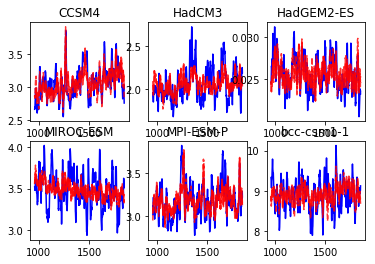

[0.46874945571614435, 0.630277308983886, 0.2278772223197092, 0.2586094322607976, 0.2993757496113032, 0.46022780953501385, 0.15371351141657164, 0.17149786549921708, 0.46057219208258826, 0.49097643064645213, 0.18618298948743606, 0.3209098400153264]


"\nlags=[0]\n\n# ts = summer_nao\n#\n# correlations_tas_summer = calculate_correlations(models,'tas',dir_tas,ts,lags)\n\ncorrelations_tas_summer = calculate_correlations(models,'tas',dir_tas,nao_dict,lags)\ncomposites_tas_summer = calculate_composites(models,'tas',dir_tas,nao_dict)\n\n# with open('/home/ph290/Documents/python_scripts/pickles/sic_psl.pickle', 'w') as f:\n#     pickle.dump([correlations_psl], f)\n\n\n\n\n\ndef plot_prep(i,correlations,c1):\n\tvar_mean = np.nanmean(correlations[i],axis=0)\n\tmean_var_cube = c1[0]\n\ttmp2 = np.ma.masked_array(var_mean)\n\tmean_var_cube.data = tmp2.data\n\treturn mean_var_cube\n\n\ndef plot_my(i,correlations,c1):\n\tvar_mean = correlations[0][i]\n\tmean_var_cube = c1[0]\n\ttmp2 = np.ma.masked_array(var_mean)\n\tmean_var_cube.data = tmp2.data\n\tqplt.contourf(mean_var_cube,21)\n\tplt.gca().coastlines()\n\tplt.show()\n\n\ndef plot_prep_comp(comp,c1):\n\tvar_mean = np.nanmean(comp,axis=0)\n\tmean_var_cube = c1[0]\n\ttmp2 = np.ma.masked_array(v

In [33]:

import numpy as np
import iris
import matplotlib.pyplot as plt
import time
import glob
from scipy import signal
import scipy
import scipy.stats
import statsmodels.api as sm
import running_mean_post as rmp
import cartopy.crs as ccrs
import iris.analysis.cartography
import numpy.ma as ma
import os
import running_mean as rm
import running_mean_post as rmp
from scipy.ndimage import gaussian_filter1d
import subprocess
import uuid
import numpy.ma as ma
import iris.plot as iplt
import matplotlib.cm as mpl_cm
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter1d
import scipy.stats as stats
import pandas
import iris.coord_categorisation
import iris.analysis
import iris.quickplot as qplt
import pickle
import iris.analysis.stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import ticker
from eofs.iris import Eof
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import iris.coord_categorisation
import numpy as np
import pandas as pd


def model_names(directory,var):
	files = glob.glob(directory+'/*_'+var+'_*.nc')
	models_tmp = []
	for file in files:
		statinfo = os.stat(file)
		if statinfo.st_size >= 1:
			models_tmp.append(file.split('/')[-1].split('_')[0])
	models = np.unique(models_tmp)
	return models



def calculate_correlations(models,var_name,my_dir,nao_dict,lags):
	lags = [0]
	lon_west = -80.0
	lon_east = 70
	lat_south = 40
	lat_north = 90
	var = np.zeros([np.size(models),180,360])
	var[:] = np.NAN
	correlations = [var]
	for i,model in enumerate(models):
		try:
			ts = nao_dict[model]['summer_nao']
			ts = scipy.signal.detrend(ts)
			ts_yr = nao_dict[model]['yr']
			print i
			c1 = iris.load_cube(my_dir + model+'_'+var_name+'_piControl_*.nc')
			iris.coord_categorisation.add_month(c1, 'time', name='month_name')
			loc = np.where((c1.coord('month_name').points == 'Jul') | (c1.coord('month_name').points == 'Aug'))
			c1 = c1[loc]
			try:
				iris.coord_categorisation.add_year(c1, 'time', name='year')
				c1 = c1.aggregated_by('year', iris.analysis.MEAN)
			except:
				print ' '
			c1_yr = c1.coord('year').points
			common_yrs = list(set(c1_yr).intersection(ts_yr))
			ts_indicies = [f for f, e in enumerate(ts_yr) if e in common_yrs]
			c1_indicies = [f for f, e in enumerate(c1_yr) if e in common_yrs]
			c1 = c1[c1_indicies]
			ts = ts[ts_indicies]
			if np.shape(c1)[0] == len(ts):
				# qplt.contourf(c1[0],31)
				# plt.gca().coastlines()
				# plt.show()
				try:
					missing_data = np.where((c1[0].data.data == c1.data.fill_value) | (c1[0].data.data == 0.0))
				except:
					missing_data = np.where(c1[0].data.data == 0.0)
				cube_data = c1.data
				cube_data_detrended = scipy.signal.detrend(cube_data, axis=0)
				c1.data = cube_data_detrended
				for j,lag in enumerate(lags):
					print 'j: ',j
					# ts = np.roll(ts,int(lag))
					# smoothing = 10
					# ts = rm.running_mean(ts,smoothing)
					# ts = ts[smoothing/2:-smoothing/2]
					# cube = c1[smoothing/2:-smoothing/2].copy()
					cube=c1
					cube = iris.analysis.maths.multiply(cube, 0.0)
					ts2 = np.swapaxes(np.swapaxes(np.tile(ts,[180,360,1]),1,2),0,1)
					cube = iris.analysis.maths.add(cube, ts2)
					# out_cube = iris.analysis.stats.pearsonr(c1[smoothing/2:-smoothing/2], cube, corr_coords=['time'])
					out_cube = iris.analysis.stats.pearsonr(c1, cube, corr_coords=['time'])

					correlations[j][i] = out_cube.data
		except:
			print 'failed'
	return correlations


def calculate_composites(models,var_name,my_dir,nao_dict):
	lags = [0]
	lon_west = -80.0
	lon_east = 70
	lat_south = 00
	lat_north = 90
	var = np.zeros([np.size(models),180,360])
	var[:] = np.NAN
	composite = var
	for i,model in enumerate(models):
		try:
			ts = nao_dict[model]['summer_nao']
			ts = scipy.signal.detrend(ts)
			ts/=np.std(ts)
			ts_yr = nao_dict[model]['yr']
			print i
			c1 = iris.load_cube(my_dir + model+'_'+var_name+'_piControl_*.nc')
			iris.coord_categorisation.add_month(c1, 'time', name='month_name')
			loc = np.where((c1.coord('month_name').points == 'Jul') | (c1.coord('month_name').points == 'Aug'))
			c1 = c1[loc]
			try:
				iris.coord_categorisation.add_year(c1, 'time', name='year')
				c1 = c1.aggregated_by('year', iris.analysis.MEAN)
			except:
				print ' '
			c1_yr = c1.coord('year').points
			common_yrs = list(set(c1_yr).intersection(ts_yr))
			ts_indicies = [f for f, e in enumerate(ts_yr) if e in common_yrs]
			c1_indicies = [f for f, e in enumerate(c1_yr) if e in common_yrs]
			c1 = c1[c1_indicies]
			ts = ts[ts_indicies]
			if np.shape(c1)[0] == len(ts):
				# qplt.contourf(c1[0],31)
				# plt.gca().coastlines()
				# plt.show()
				try:
					missing_data = np.where((c1[0].data.data == c1.data.fill_value) | (c1[0].data.data == 0.0))
				except:
					missing_data = np.where(c1[0].data.data == 0.0)
				cube_data = c1.data
				cube_data_detrended = scipy.signal.detrend(cube_data, axis=0)
				c1.data = cube_data_detrended
				loc = np.where(ts > 0.5)
				composite[i] = c1[loc].collapsed('time',iris.analysis.MEAN).data
		except:
			print 'failed'
	return composite


def summer_nao(cube):
	#defined as the leading EOF of July August mean SLP in the domain 40N 70N 90W 30E Blade2011
	iris.coord_categorisation.add_month(cube, 'time', name='month_name')
	loc = np.where((cube.coord('month_name').points == 'Jul') | (cube.coord('month_name').points == 'Aug'))
	cube = cube[loc]
	iris.coord_categorisation.add_year(cube, 'time', name='year')
	cube = cube.aggregated_by('year', iris.analysis.MEAN)
	lon_west = -90.0
	lon_east = 30.0
	lat_south = 40.0
	lat_north = 70.0
	cube = cube.intersection(longitude=(lon_west, lon_east))
	cube = cube.intersection(latitude=(lat_south, lat_north))
	solver = Eof(cube, weights='coslat')
	#eofs = solver.eofs(neofs=5)
	eof1 = solver.eofsAsCorrelation(neofs=1)[0]
	pc1 = solver.pcs(npcs=1, pcscaling=1)
	# plt.close('all')
	# qplt.contourf(eof1,31)
	# plt.gca().coastlines()
	# plt.show(block = False)
	yr = cube.coord('year').points
	return yr,pc1[:,0].data


def calc_ao(cube):
	#NOte tHIS IS NOT RIGHT!
	iris.coord_categorisation.add_year(cube, 'time', name='year')
	cube = cube.aggregated_by('year', iris.analysis.MEAN)
	lon_west = -180.0
	lon_east = 180.0
	lat_south = 20.0
	lat_north = 90.0
	cube = cube.intersection(longitude=(lon_west, lon_east))
	cube = cube.intersection(latitude=(lat_south, lat_north))
	solver = Eof(cube, weights='coslat')
	#eofs = solver.eofs(neofs=5)
	eof1 = solver.eofsAsCorrelation(neofs=1)[0]
	pc1 = solver.pcs(npcs=1, pcscaling=1)
	# plt.close('all')
	# qplt.contourf(eof1,31)
	# plt.gca().coastlines()
	# plt.show(block = False)
	yr = cube.coord('year').points
	return yr,pc1[:,0].data



def point_timeseries(cube,my_lat,my_lon):
	try:
	    cube.coord('latitude').guess_bounds()
	except:
	    pass
	try:
	    cube.coord('longitude').guess_bounds()
	except:
	    pass
	lat = cube.coord('latitude')
	lon = cube.coord('longitude')
	lat_coord1 = lat.nearest_neighbour_index(my_lat)
	lon_coord1 = lon.nearest_neighbour_index(my_lon)
	return cube[:,lat_coord1,lon_coord1].data


def normalise(input):
	return ((input-np.nanmin(input))/(np.nanmax(input) - np.nanmin(input)))


def winter_nao(cube):
	#based on https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-station-based
	#defined as the difference of December thru March normalized (each normalised 1st) sea level pressure (SLP) between Lisbon, Portugal and Stykkisholmur/Reykjavik, Iceland
	iris.coord_categorisation.add_month(cube, 'time', name='month_name')
	loc = np.where((cube.coord('month_name').points == 'Dec') | (cube.coord('month_name').points == 'Jan') | (cube.coord('month_name').points == 'Feb') | (cube.coord('month_name').points == 'Mar'))
	cube = cube[loc]
	try:
		iris.coord_categorisation.add_year(cube, 'time', name='year')
	except:
		pass
	cube = cube.aggregated_by('year', iris.analysis.MEAN)
	iceland_slp = point_timeseries(cube,64.1466,-21.9426)
	lisbon_slp = point_timeseries(cube,38.7223,-9.1393)
	year = cube.coord('year').points
	return year, normalise(lisbon_slp) - normalise(iceland_slp)


def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)


def amo(cube):
	lon_west = -75.0
	lon_east = -7.5
	lat_south = 0.0
	lat_north = 60.0
	cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
	cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
	try:
		iris.coord_categorisation.add_year(cube, 'time', name='year')
	except:
		pass
	year = cube.coord('year').points
	return year,area_avg(cube_region)


def sic_region(cube):
	lon_west = -45.0
	lon_east = 25.0
	lat_south = 0.0
	lat_north = 90.0
	cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
	cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
	try:
		iris.coord_categorisation.add_year(cube, 'time', name='year')
	except:
		pass
	year = cube.coord('year').points
	return year,area_avg(cube_region)

def cube_region(cube,lon_west,lon_east,lat_south,lat_north):
	cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
	cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
	try:
		iris.coord_categorisation.add_year(cube, 'time', name='year')
	except:
		pass
	year = cube.coord('year').points
	return year,area_avg(cube_region)

def calc_mlr(y,xs):
	import numpy as np
	import statsmodels.api as sm
	import matplotlib.pyplot as plt
	#xs should be an array of all of the potential explanatory variables [x1,x2,x3...]
	x=np.column_stack([x for x in xs])
	#stack explanatory variables into an array
	x = sm.add_constant(x)
	#add constant to first column for some reasons
	model = sm.OLS(y,x)
	results = model.fit()
	y2 = results.params[0]
	for i in range(np.size(results.params))[1::]:
		y2 = y2 + results.params[i]*xs[i-1]
	return y2,results





dir_psl = '/data/NAS-ph290/ph290/cmip5/past1000/monthly/'
# dir_tas = '/data/NAS-ph290/ph290/cmip5/piControl/monthly/'
dir_tos = '/data/NAS-ph290/ph290/cmip5/last1000/'
dir_sic = '/data/NAS-ph290/ph290/cmip5/last1000/'

m1 = model_names(dir_psl,'psl')
m2 = model_names(dir_tos,'tos')
m3 = model_names(dir_sic,'sic')
# m4 = model_names(dir_sic,'sic')


models = np.intersect1d(m1,m2)
models = np.intersect1d(models,m3)
# models = np.intersect1d(models,m4)


models = list(models)
# Mainly removed to avoid biasing multi-model mean by using large numbers of closely related models.
# models_to_remove = ['CNRM-CM5-2','CESM1-CAM5','CESM1-FASTCHEM','CESM1-WACCM','inmcm4','MPI-ESM-LR','MPI-ESM-P','NorESM1-ME','GFDL-CM3']
models_to_remove=['CSIRO-Mk3L-1-2']

for m in models_to_remove:
	try:
		models.remove(m)
	except:
		print m+' not availiable to remove'

###########
# set up dictionary
###########
timeseries_dict = {}
for model in models:
	print model
	timeseries_dict[model] = {}
	timeseries_dict[model]['yr'] = np.arange(950,1851)




with open('/home/ph290/Documents/python_scripts/pickles/nao_dict_last1000.pickle', 'r') as f:
    [timeseries_dict,models] = pickle.load(f)

"""

#summer NAO
for model in models:
	print 'summer nao calculation for: ', model
	# try:
	cube = iris.load_cube(dir_psl+model+'_psl_past1000_r1i1p1*.nc')
	yr,pc1 = summer_nao(cube)
	tmp_yr = timeseries_dict[model]['yr']
	tmp_data = np.zeros(len(tmp_yr))
	tmp_data[:] = np.nan
	for i,tmp_yr_tmp in enumerate(tmp_yr):
		loc = np.where(yr == tmp_yr_tmp)
		if np.size(loc) == 1:
			tmp_data[i] = pc1[loc[0][0]]

	timeseries_dict[model]['summer_nao'] = tmp_data
	# except:
	# 	print model+' failed'


#winter NAO
for model in models:
	print 'winter NAO calculation for: ', model
	# try:
	cube = iris.load_cube(dir_psl+model+'_psl_past1000_r1i1p1*nc')
	yr,nao = winter_nao(cube)
	tmp_yr = timeseries_dict[model]['yr']
	tmp_data = np.zeros(len(tmp_yr))
	tmp_data[:] = np.nan
	for i,tmp_yr_tmp in enumerate(tmp_yr):
		loc = np.where(yr == tmp_yr_tmp)
		if np.size(loc) == 1:
			tmp_data[i] = nao[loc[0][0]]

	timeseries_dict[model]['winter_nao'] = tmp_data
	# except:
	# 	print model+' failed'


#AMO
for model in models:
	print 'AMO calculation for: ',model
	# try:
	cube = iris.load_cube(dir_tos+model+'_tos_past1000_r1i1p1*.nc')
	yr,amo_data = amo(cube)
	tmp_yr = timeseries_dict[model]['yr']
	tmp_data = np.zeros(len(tmp_yr))
	tmp_data[:] = np.nan
	for i,tmp_yr_tmp in enumerate(tmp_yr):
		loc = np.where(yr == tmp_yr_tmp)
		if np.size(loc) == 1:
			tmp_data[i] = amo_data[loc[0][0]].data

	timeseries_dict[model]['amo'] = tmp_data
	# except:
	# 	print model+' failed'



#sic
for model in models:
	print 'sic calculation for: ', model
	# try:
	cube = iris.load_cube(dir_sic+model+'_sic_past1000_r1i1p1_*regridded.nc')
	yr,sic_region_data = sic_region(cube)
	tmp_yr = timeseries_dict[model]['yr']
	tmp_data = np.zeros(len(tmp_yr))
	tmp_data[:] = np.nan
	for i,tmp_yr_tmp in enumerate(tmp_yr):
		loc = np.where(yr == tmp_yr_tmp)
		if np.size(loc) == 1:
			tmp_data[i] = sic_region_data[loc[0][0]].data

	timeseries_dict[model]['sic'] = tmp_data
		# except:
		# 	print model+' failed'


#ice psl
for model in models:
	lon_west = -180
	lon_east = 180
	lat_south = 80.0
	lat_north = 90.0
	print 'ice region psl calculation for: ', model
	cube = iris.load_cube(dir_psl+model+'_psl_past1000_r1i1p1*nc')
	try:
		iris.coord_categorisation.add_year(cube, 'time', name='year')
	except:
		pass
	cube = cube.aggregated_by('year', iris.analysis.MEAN)
	yr,region_data = cube_region(cube,lon_west,lon_east,lat_south,lat_north)
	tmp_yr = timeseries_dict[model]['yr']
	tmp_data = np.zeros(len(tmp_yr))
	tmp_data[:] = np.nan
	for i,tmp_yr_tmp in enumerate(tmp_yr):
		loc = np.where(yr == tmp_yr_tmp)
		if np.size(loc) == 1:
			tmp_data[i] = region_data[loc[0][0]].data

	timeseries_dict[model]['ice_psl'] = tmp_data


#beaufort gyre psl
for model in models:
	lon_west = 170
	lon_east = 360-20
	lat_south = 80.0
	lat_north = 90.0
	print 'ice region psl calculation for: ', model
	cube = iris.load_cube(dir_psl+model+'_psl_past1000_r1i1p1*nc')
	try:
		iris.coord_categorisation.add_year(cube, 'time', name='year')
	except:
		pass

	cube = cube.aggregated_by('year', iris.analysis.MEAN)
	yr,region_data = cube_region(cube,lon_west,lon_east,lat_south,lat_north)
	tmp_yr = timeseries_dict[model]['yr']
	tmp_data = np.zeros(len(tmp_yr))
	tmp_data[:] = np.nan
	for i,tmp_yr_tmp in enumerate(tmp_yr):
		loc = np.where(yr == tmp_yr_tmp)
		if np.size(loc) == 1:
			tmp_data[i] = region_data[loc[0][0]].data

	timeseries_dict[model]['beaufort_psl'] = tmp_data


#east arctic  psl
for model in models:
	lon_west = -20
	lon_east = 180
	lat_south = 80.0
	lat_north = 90.0
	print 'ice region psl calculation for: ', model
	cube = iris.load_cube(dir_psl+model+'_psl_past1000_r1i1p1*nc')
	try:
		iris.coord_categorisation.add_year(cube, 'time', name='year')
	except:
		pass

	cube = cube.aggregated_by('year', iris.analysis.MEAN)
	yr,region_data = cube_region(cube,lon_west,lon_east,lat_south,lat_north)
	tmp_yr = timeseries_dict[model]['yr']
	tmp_data = np.zeros(len(tmp_yr))
	tmp_data[:] = np.nan
	for i,tmp_yr_tmp in enumerate(tmp_yr):
		loc = np.where(yr == tmp_yr_tmp)
		if np.size(loc) == 1:
			tmp_data[i] = region_data[loc[0][0]].data

	timeseries_dict[model]['east_arctic_psl'] = tmp_data


#iceland  psl
for model in models:
	lon_west = -22
	lon_east = 12
	lat_south = 65
	lat_north = 75
	print 'ice region psl calculation for: ', model
	cube = iris.load_cube(dir_psl+model+'_psl_past1000_r1i1p1*nc')
	try:
		iris.coord_categorisation.add_year(cube, 'time', name='year')
	except:
		pass

	cube = cube.aggregated_by('year', iris.analysis.MEAN)
	yr,region_data = cube_region(cube,lon_west,lon_east,lat_south,lat_north)
	tmp_yr = timeseries_dict[model]['yr']
	tmp_data = np.zeros(len(tmp_yr))
	tmp_data[:] = np.nan
	for i,tmp_yr_tmp in enumerate(tmp_yr):
		loc = np.where(yr == tmp_yr_tmp)
		if np.size(loc) == 1:
			tmp_data[i] = region_data[loc[0][0]].data

	timeseries_dict[model]['iceland_psl'] = tmp_data

#AO
for model in models:
	print 'winter NAO calculation for: ', model
	# try:
	cube = iris.load_cube(dir_psl+model+'_psl_past1000_r1i1p1*nc')
	yr,nao = calc_ao(cube)
	tmp_yr = timeseries_dict[model]['yr']
	tmp_data = np.zeros(len(tmp_yr))
	tmp_data[:] = np.nan
	for i,tmp_yr_tmp in enumerate(tmp_yr):
		loc = np.where(yr == tmp_yr_tmp)
		if np.size(loc) == 1:
			tmp_data[i] = nao[loc[0][0]]

	timeseries_dict[model]['ao'] = tmp_data
	# except:
	# 	print model+' failed'


with open('/home/ph290/Documents/python_scripts/pickles/nao_dict_last1000.pickle', 'w') as f:
    pickle.dump([timeseries_dict,models], f)


"""

my_window=10
adj_r2s = []

f, axarr = plt.subplots(3,2)
for i,model in enumerate(models):
	yr = timeseries_dict[model]['yr']
	y = pd.DataFrame(timeseries_dict[model]['sic']).rolling(window=my_window,center=False).mean().values
	x1 = pd.DataFrame(timeseries_dict[model]['summer_nao']).rolling(window=my_window,center=False).mean().values
	x2 = pd.DataFrame(timeseries_dict[model]['winter_nao']).rolling(window=my_window,center=False).mean().values
	x3 = pd.DataFrame(timeseries_dict[model]['amo']).rolling(window=my_window,center=False).mean().values
	x4 = pd.DataFrame(timeseries_dict[model]['beaufort_psl']).rolling(window=my_window,center=False).mean().values
	x5 = pd.DataFrame(timeseries_dict[model]['east_arctic_psl']).rolling(window=my_window,center=False).mean().values
	x6 = pd.DataFrame(timeseries_dict[model]['ao']).rolling(window=my_window,center=False).mean().values
	loc = np.where((np.isfinite(x1)) & (np.isfinite(x2)) &(np.isfinite(x3)) &(np.isfinite(x4)) &(np.isfinite(x5)) &(np.isfinite(x6)))
	yr = yr[loc[0]]
	# y = signal.detrend(np.reshape(y[loc[0]],np.size(y[loc[0]])))
	# x1 = signal.detrend(np.reshape(x1[loc[0]],np.size(y)))
	# x2 = signal.detrend(np.reshape(x2[loc[0]],np.size(y)))
	# x3 = signal.detrend(np.reshape(x3[loc[0]],np.size(y)))
	# x4 = signal.detrend(np.reshape(x4[loc[0]],np.size(y)))
	# x5 = signal.detrend(np.reshape(x5[loc[0]],np.size(y)))
	# x6 = signal.detrend(np.reshape(x6[loc[0]],np.size(y)))
	y = y[loc[0]]
	x1 = x1[loc[0]]
	x2 = x2[loc[0]]
	x3 = x3[loc[0]]
	x4 = x4[loc[0]]
	x5 = x5[loc[0]]
	x6 = x6[loc[0]]
	# adj_r2s = []
	# lags = range(-100,100)
	# for i in lags:
	# 	xs = [np.roll(x3,i),x4,x5,x6]
	# 	y2,results = calc_mlr(y,xs)
	# 	adj_r2s.append(results.rsquared_adj)
	# best_i =  np.where(adj_r2s == np.max(adj_r2s))[0][0]
	# i=lags[best_i]
	# xs = [np.roll(x3,i),x4,x5,x6]
	xs = [x2,x3]
	y2,results = calc_mlr(y,xs)
	adj_r2s.append(results.rsquared_adj)
	plt.subplot(2, 3, i+1)
	plt.plot(yr,y,'b')
	plt.plot(yr,y2,'r',alpha=0.8)
	plt.title(model)
	# xs = [x2,x4,x5]
	# y2,results = calc_mlr(y,xs)
	# plt.plot(yr,y2,'k',alpha=0.5)
	# xs = [x3,x5]
	# y2,results = calc_mlr(y,xs)
	# plt.plot(yr,y2,'r',alpha=0.3)
	# xs = [x3,x4]
	# y2,results = calc_mlr(y,xs)
	# plt.plot(yr,y2,'r',alpha=0.3)
	xs = [x2,x3,x4,x5,x6]
	y2,results = calc_mlr(y,xs)
	adj_r2s.append(results.rsquared_adj)
	plt.subplot(2, 3, i+1)
	plt.plot(yr,y2,'r--',alpha=0.8)
	# xs = [x2,x4,x5]
	# y2,results = calc_mlr(y,xs)
	# plt.plot(yr,y2,'k',alpha=0.5)
	# xs = [x3,x5]
	# y2,results = calc_mlr(y,xs)
	# plt.plot(yr,y2,'r',alpha=0.3)
	# xs = [x3,x4]
	# y2,results = calc_mlr(y,xs)
	# plt.plot(yr,y2,'r',alpha=0.3)

plt.savefig('/home/ph290/Documents/figures/seaice_drivers_amo_NAO.png')
plt.show()


print adj_r2s

# x2-5 [0.6303758454756261, 0.2594438036343717, 0.17228331560743526, 0.4769552493889814, 0.31985129948207813]
# x2-4 [0.499209921334983, 0.2276361293679512, 0.15758880364923078, 0.46785601842913105, 0.27573158629805916]
# x3-4 [0.48631620871663783, 0.21709352167760976, 0.08547878822496613, 0.3995634323143945, 0.23906967328108808]
# x3 and x5 [0.5416088332314878, 0.22251241873031224, 0.08216151259265148, 0.39790671434467917, 0.2629055684377154]
# x2 and x3 [0.46874945571614435, 0.2278772223197092, 0.15371351141657164, 0.46057219208258826, 0.18618298948743606]

"""
lags=[0]

# ts = summer_nao
#
# correlations_tas_summer = calculate_correlations(models,'tas',dir_tas,ts,lags)

correlations_tas_summer = calculate_correlations(models,'tas',dir_tas,nao_dict,lags)
composites_tas_summer = calculate_composites(models,'tas',dir_tas,nao_dict)

# with open('/home/ph290/Documents/python_scripts/pickles/sic_psl.pickle', 'w') as f:
#     pickle.dump([correlations_psl], f)





def plot_prep(i,correlations,c1):
	var_mean = np.nanmean(correlations[i],axis=0)
	mean_var_cube = c1[0]
	tmp2 = np.ma.masked_array(var_mean)
	mean_var_cube.data = tmp2.data
	return mean_var_cube


def plot_my(i,correlations,c1):
	var_mean = correlations[0][i]
	mean_var_cube = c1[0]
	tmp2 = np.ma.masked_array(var_mean)
	mean_var_cube.data = tmp2.data
	qplt.contourf(mean_var_cube,21)
	plt.gca().coastlines()
	plt.show()


def plot_prep_comp(comp,c1):
	var_mean = np.nanmean(comp,axis=0)
	mean_var_cube = c1[0]
	tmp2 = np.ma.masked_array(var_mean)
	mean_var_cube.data = tmp2.data
	return mean_var_cube





#################################



# plt.close('all')
# plt.figure(figsize=(12, 5))
#
#
# ######### Subplot 1 #########
#
# var_name = 'psl'
# c1 = iris.load_cube(dir_psl + models[0]+'_'+var_name+'_piControl_*.nc')
# mean_var_cube = plot_prep(0,correlations_psl,c1)
#
# my_projection = ccrs.Orthographic(central_longitude=-20, central_latitude=60)
# ax = plt.subplot(1,2,1,projection= my_projection)
# ax.set_extent([-180, 180, 35, 90], crs=ccrs.PlateCarree())
#
# cube1 = mean_var_cube
# lats1 = cube1.coord('latitude').points
# lons1 = cube1.coord('longitude').points
# data1 = cube1.data
#
#
# contour_result1 = ax.contourf(lons1, lats1, data1,np.linspace(-0.5,0.5,31),
# 			transform=ccrs.PlateCarree(),cmap='jet')
#
# cb = plt.colorbar(contour_result1, orientation='horizontal')
# # plt.clabel(contour_result1, inline=1, fontsize=10)
# tick_locator = ticker.MaxNLocator(nbins=5)
# cb.locator = tick_locator
# cb.update_ticks()
#
# # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
# # river_50m = cfeature.NaturalEarthFeature('phypslal', 'rivers_lake_centerlines_scale_rank', '10m',facecolor='none')
# # land_50m = cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='none')
# coast_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',facecolor='none')
# # glacier_50m = cfeature.NaturalEarthFeature('phypslal', 'glaciated_areas', '10m',facecolor='none')
# # river_euro_50m = cfeature.NaturalEarthFeature('phypslal', 'rivers_europe', '10m',facecolor='none')
#
# # ax.add_feature(land_50m,facecolor='#D3D3D3')
# ax.add_feature(coast_50m)
# # ax.add_feature(river_50m, edgecolor='blue',alpha=0.5)
# # ax.add_feature(glacier_50m, facecolor='grey',alpha=0.5)
# # ax.add_feature(river_euro_50m, edgecolor='blue',alpha=0.5)
#
# plt.title('Control run sic sea level pressure correlation\n(lag = 0)')
#
# plt.plot(-18.195667,66.5215, 'ro', transform=ccrs.PlateCarree())
# #66 31.59 N, 18 11.74 W
# plt.plot(15.73,68.80, color='brown',marker='o', transform=ccrs.PlateCarree())
#
# # x, y = [-80.0, -80.0, 70, 70, -80.0], [40, 90, 90, 40, 40]
# # ax.plot(x, y,'o',transform=ccrs.PlateCarree())
# # ax.fill(x, y, color='coral', transform=ccrs.PlateCarree(), alpha=0.4)
# ax.gridlines()
#
#
#
# plt.tight_layout()
# plt.savefig('/home/ph290/Documents/figures/sic_psl_pi_cont_composites_alternative2.png')
# plt.show(block = False)

for i in range(np.shape(correlations_tas_summer)[1]):
	if correlations_tas_summer[0][i][164][140] > 1.0:
		correlations_tas_summer[0,i,:,:] = correlations_tas_summer[0,i,:,:] * -1.0


###########

plt.close('all')
plt.figure(figsize=(12, 10))

######### Subplot 1 #########

var_name = 'psl'
c1 = iris.load_cube(dir_psl + models[0]+'_'+var_name+'_piControl_*.nc')
mean_var_cube = plot_prep(0,correlations_tas_summer,c1)

my_projection = ccrs.Orthographic(central_longitude=-20, central_latitude=60)
ax = plt.subplot2grid((2, 1), (0, 0),projection= my_projection)

ax.set_extent([-180, 180, 35, 90], crs=ccrs.PlateCarree())

cube1 = mean_var_cube
lats1 = cube1.coord('latitude').points
lons1 = cube1.coord('longitude').points
data1 = cube1.data

contour_result1 = ax.contourf(lons1, lats1, data1,np.linspace(-0.1,0.1,31),
			transform=ccrs.PlateCarree(),cmap='jet')

cb = plt.colorbar(contour_result1, orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label('R')

coast_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',facecolor='none')
ax.add_feature(coast_50m,edgecolor='#000000',alpha = 0.3)
plt.title('tas - summer NAO\n(control run)')
plt.plot(-18.195667,66.5215, 'k*',markersize = 20, transform=ccrs.PlateCarree())
plt.plot(15.73,68.80, color='#808080',marker='o',markersize = 10, transform=ccrs.PlateCarree())
ax.gridlines()
#
# ######### Subplot 2 #########
#
# var_name = 'tas'
# c1 = iris.load_cube(dir_tas + models[0]+'_'+var_name+'_piControl_*.nc')
# mean_var_cube = plot_prep(0,correlations_tas_winter,c1)
#
# my_projection = ccrs.Orthographic(central_longitude=-20, central_latitude=60)
# ax = plt.subplot2grid((2, 1), (1, 0),projection= my_projection)
# ax.set_extent([-180, 180, 35, 90], crs=ccrs.PlateCarree())
#
# cube1 = mean_var_cube
# lats1 = cube1.coord('latitude').points
# lons1 = cube1.coord('longitude').points
# data1 = cube1.data
#
#
# contour_result1 = ax.contourf(lons1, lats1, data1,np.linspace(-0.7,0.7,31),
# 			transform=ccrs.PlateCarree(),cmap='jet')
#
# cb = plt.colorbar(contour_result1, orientation='horizontal')
# tick_locator = ticker.MaxNLocator(nbins=5)
# cb.locator = tick_locator
# cb.update_ticks()
# cb.set_label('R')
# coast_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',facecolor='none')
# ax.add_feature(coast_50m,edgecolor='#000000',alpha = 0.3)
# plt.title('Sea-ice tas correlation\n(control run)')
#
# plt.plot(-18.195667,66.5215, 'k*',markersize = 20, transform=ccrs.PlateCarree())
#
# plt.plot(15.73,68.80, color='#808080',marker='o',markersize = 10, transform=ccrs.PlateCarree())
# ax.gridlines()


plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/tas_nao_sum_wint.png')
plt.show(block = False)

############
#composites#
############


plt.close('all')
plt.figure(figsize=(12, 10))

######### Subplot 1 #########

var_name = 'psl'
c1 = iris.load_cube(dir_psl + models[0]+'_'+var_name+'_piControl_*.nc')
mean_var_cube = plot_prep_comp(composites_tas_summer,c1)

my_projection = ccrs.Orthographic(central_longitude=-20, central_latitude=60)
ax = plt.subplot2grid((2, 1), (0, 0),projection= my_projection)

ax.set_extent([-180, 180, 35, 90], crs=ccrs.PlateCarree())

cube1 = mean_var_cube
lats1 = cube1.coord('latitude').points
lons1 = cube1.coord('longitude').points
data1 = cube1.data

contour_result1 = ax.contourf(lons1, lats1, data1,np.linspace(-0.2,0.2,31),
			transform=ccrs.PlateCarree(),cmap='jet')

cb = plt.colorbar(contour_result1, orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label('R')

coast_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',facecolor='none')
ax.add_feature(coast_50m,edgecolor='#000000',alpha = 0.3)
plt.title('tas - summer NAO composite\n(control run)')
plt.plot(-18.195667,66.5215, 'k*',markersize = 20, transform=ccrs.PlateCarree())
plt.plot(15.73,68.80, color='#808080',marker='o',markersize = 10, transform=ccrs.PlateCarree())
ax.gridlines()

plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/tas_nao_sum_wint_composite.png')
plt.show(block = False)
"""


In [8]:
print adj_r2s


[0.46874945571614435, 0.2278772223197092, 0.2993757496113032, 0.15371351141657164, 0.46057219208258826, 0.18618298948743606]


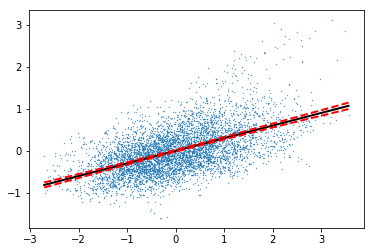

<Figure size 432x288 with 0 Axes>

In [34]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

combinations = ['x2x3','x1x2x3','x2x3x4','x2x3x4x5','x2x3x4x5x6']
combinations = ['x2x3']

my_data = {}
for combination in combinations:
    my_data[combination]={}
    my_data[combination]['final_y1s'] = []
    my_data[combination]['final_y2s'] = []
    for i,model in enumerate(models):
        yr = timeseries_dict[model]['yr']
        y = pd.DataFrame(timeseries_dict[model]['sic']).rolling(window=my_window,center=False).mean().values
        x1 = pd.DataFrame(timeseries_dict[model]['summer_nao']).rolling(window=my_window,center=False).mean().values
        x2 = pd.DataFrame(timeseries_dict[model]['winter_nao']).rolling(window=my_window,center=False).mean().values
        x3 = pd.DataFrame(timeseries_dict[model]['amo']).rolling(window=my_window,center=False).mean().values
        x4 = pd.DataFrame(timeseries_dict[model]['beaufort_psl']).rolling(window=my_window,center=False).mean().values
        x5 = pd.DataFrame(timeseries_dict[model]['east_arctic_psl']).rolling(window=my_window,center=False).mean().values
        x6 = pd.DataFrame(timeseries_dict[model]['ao']).rolling(window=my_window,center=False).mean().values
        loc = np.where((np.isfinite(x1)) & (np.isfinite(x2)) &(np.isfinite(x3)) &(np.isfinite(x4)) &(np.isfinite(x5)) &(np.isfinite(x6)))
        yr = yr[loc[0]]

        y = y[loc[0]]
        x1 = x1[loc[0]]
        x2 = x2[loc[0]]
        x3 = x3[loc[0]]
        x4 = x4[loc[0]]
        x5 = x5[loc[0]]
        x6 = x6[loc[0]]

        if combination == 'x2x3':
            xs = [x2,x3]
        if combination == 'x1x2x3':
            xs = [x1,x2,x3]
        if combination == 'x2x3x4':
            xs = [x2,x3,x4]
        if combination == 'x2x3x4x5':
            xs = [x2,x3,x4,x5]
        if combination == 'x2x3x4x5x6':
            xs = [x2,x3,x4,x5,x6]
        y2,results = calc_mlr(y,xs)
        adj_r2s.append(results.rsquared_adj)
        tmp = np.mean(y)
        y -= tmp
        y2 -= tmp
        tmp = np.std(y)
        y /= tmp
        y2 /= tmp

        my_data[combination]['final_y1s'] = np.append(my_data[combination]['final_y1s'],y)
        my_data[combination]['final_y2s'] = np.append(my_data[combination]['final_y2s'],y2)



for combination in combinations:
    y = my_data[combination]['final_y2s']
    x = my_data[combination]['final_y1s']

    xsort = np.argsort(x)
    x = x[xsort]
    y = y[xsort]

    xb = sm.add_constant(x)
    model = sm.OLS(y,xb)
    results = model.fit()

    x2 = np.linspace(np.min(x),np.max(x),np.size(x))
    y2 = results.predict(sm.add_constant(x2))


    st, data, ss2 = summary_table(results, alpha=0.001)
    fittedvalues = data[:,2]
    predict_mean_se  = data[:,3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
    predict_ci_low, predict_ci_upp = data[:,6:8].T

    plt.scatter(x,y,s=0.1)
    plt.plot(x, fittedvalues, 'k', lw=2)
    # plt.plot(x, predict_ci_low, 'r--', lw=2)
    # plt.plot(x, predict_ci_upp, 'r--', lw=2)
    plt.plot(x, predict_mean_ci_low, 'r--', lw=2)
    plt.plot(x, predict_mean_ci_upp, 'r--', lw=2)


plt.show()




plt.savefig('/home/ph290/Documents/figures/seaice_drivers_amo_NAO_scatter.png')
plt.show()

[-2.71219099 -2.69033667 -2.66107266 ...  3.40658311  3.49631732
  3.55937411]
